In [1]:
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as up
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [60]:
def model_fit_and_plot(xdata, ydata, model, parameters):
    '''Fit a line or curve, and plot/show the fit results.
    The function returns a parameters object with the fit parameters.
    '''

    my_params = parameters
    my_model = model
    model_fit=my_model.fit(ydata, params=my_params, x=xdata)
    #plt.plot(xdata, model_fit.best_fit, '-', label='fit')
    #plt.plot(xdata, ydata, 'o', label='raw data')
    plt.legend()
    plt.title('Fitted data')
    model_fit
    return model_fit.params

In [3]:
# Model to fit to (see https://lmfit.github.io/lmfit-py/builtin_models.html#sinemodel)
from lmfit.models import ExpressionModel
mod = ExpressionModel('off + amp * (sin(x*freq + phase))**2')

from numpy import linspace, sin
x = linspace(0, 10, 500)
params = mod.make_params(off=0.25, amp=1.0, freq=2, phase=0)
#y=mod.eval(params, x=x)



In [4]:
# File opener function to extract data to an array
def fileOpener(file_name, data_columns, file_name2 = None, data_columns2 = ()):
    def columnExtractor(file_name, data_columns):
        def generatorHelper(file):
            for line in file:
                splitted = line.split('\t')
                yield splitted[data_columns[0]]
                yield splitted[data_columns[1]]

        with open(file_name, 'r') as file:
            print(f"Opening file: {file_name}")
            generator = generatorHelper(file)
            result = np.fromiter(generator, dtype = float)
            print(f"Closing file: {file_name}")

        return result.reshape((-1, 2))

    rawdata = columnExtractor(file_name, data_columns)

    if file_name2:
        rawdata2 = columnExtractor(file_name2, data_columns2 if len(data_columns2) != 0 else data_columns)

        if len(rawdata2) > len(rawdata):
            rawdata2 = rawdata2[-len(rawdata):]
        elif len(rawdata) > len(rawdata2):
            rawdata = rawdata[-len(rawdata2):]

        rawdata = np.column_stack((rawdata, rawdata2))

    print(rawdata.shape)
    return rawdata

In [5]:
# Column 0 is time, column 1 is time series, column 3 is the control. Want to take 1 and 3
file_name1= r"C:\Users\18434\Downloads\Colim_35.lvm"
test=fileOpener(file_name1, [0,3])

Opening file: C:\Users\18434\Downloads\Colim_35.lvm
Closing file: C:\Users\18434\Downloads\Colim_35.lvm
(901932, 2)


In [6]:
x_data = test[:, 0]
y_data = test[:, 1]


C:\Users\18434\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\18434\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


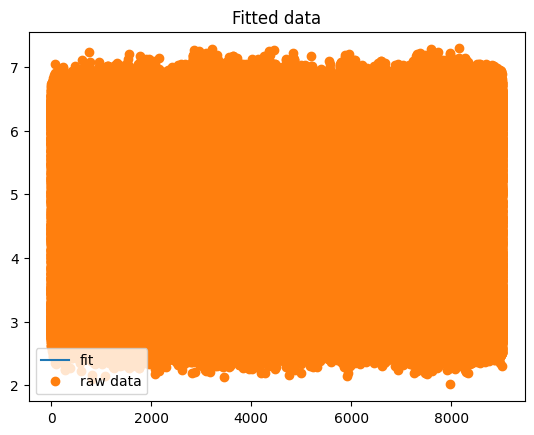

In [7]:
my_mod =model_fit_and_plot(x_data, y_data, mod, params)

In [21]:
print(my_mod)

Parameters([('off', <Parameter 'off', value=4.684741908762386 +/- 0.00252, bounds=[-inf:inf]>), ('amp', <Parameter 'amp', value=0.0002635698962083696 +/- 0.00415, bounds=[-inf:inf]>), ('freq', <Parameter 'freq', value=2.000427005714154 +/- 0.00913, bounds=[-inf:inf]>), ('phase', <Parameter 'phase', value=-2.0505432467141436 +/- 47.2, bounds=[-inf:inf]>)])


In [ ]:
import numpy as np
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
from gwpy.plot import BodePlot
import matplotlib
matplotlib.use('QtAgg')
from matplotlib import pyplot as plt

def fileOpener(file_name, data_columns, file_name2 = None, data_columns2 = ()):
    def columnExtractor(file_name, data_columns):
        def generatorHelper(file):
            for line in file:
                splitted = line.split('\t')
                yield splitted[data_columns[0]]
                yield splitted[data_columns[1]]

        with open(file_name, 'r') as file:
            print(f"Opening file: {file_name}")
            generator = generatorHelper(file)
            result = np.fromiter(generator, dtype = float)
            print(f"Closing file: {file_name}")

        return result.reshape((-1, 2))

    rawdata = columnExtractor(file_name, data_columns)

    if file_name2:
        rawdata2 = columnExtractor(file_name2, data_columns2 if len(data_columns2) != 0 else data_columns)

        if len(rawdata2) > len(rawdata):
            rawdata2 = rawdata2[-len(rawdata):]
        elif len(rawdata) > len(rawdata2):
            rawdata = rawdata[-len(rawdata2):]

        rawdata = np.column_stack((rawdata, rawdata2))

    print(rawdata.shape)
    return rawdata

# this is our file opener: it reads each line and takes out the \n for a new
# line and then takes the len of each column. Then we make empty arrays the
# size of each column and fill it with the columns we want from the data.
# Then the file is closed which is good book keeping

def cutData(data, front_cut, _sample_rate, back_cut = -1):
    a = data[:,0]
    b = data[:,1]
    data1 = TimeSeries(a[front_cut:back_cut], sample_rate = _sample_rate)
    data2 = TimeSeries(b[front_cut:back_cut], sample_rate = _sample_rate)
    #print(data)
    if len(data[0]) == 4:
        a1 = data[:,2]
        b1 = data[:,3]
        data3 = TimeSeries(a1[front_cut:back_cut], sample_rate = _sample_rate)
        data4 = TimeSeries(b1[front_cut:back_cut], sample_rate = _sample_rate)
        return (data1, data2, data3, data4)
    else:
        return (data1, data2)

# This cuts the data from file opener and returns it as a gwpy timeseries with
# a given sample rate

def iFreqSeries(cutData, _fftlength, _overlap):
    data1 = cutData[0].psd(fftlength = _fftlength, overlap = _overlap)
    data2 = cutData[1].psd(fftlength = _fftlength, overlap = _overlap)
    if len(cutData) == 4:
        data3 = cutData[2].psd(fftlength = _fftlength, overlap = _overlap)
        data4 = cutData[3].psd(fftlength = _fftlength, overlap = _overlap)
        return (data1, data2, data3, data4)
    else:
        return(data1, data2)


def w(start, stop):
    start = data.f0.value
    stop = data.df.value
    freq = np.arange(start, stop, 0.00166667)
    w = freq.FrequencySeries
    w = 2*np.pi*w
#data = data[1:-(501+4400+100-1)]
#data2 = data2[1:-(501+4400+100-1)]


#print(data)
#print(w)
#print(len(w))
#print(len(data))
#print(data/w)

# This turns our columns from our data into a 2D array that we can manipulate
# a little more easily. Make sure you include sample rate for the timeseries.
# Resampled in labview cuts out the top end of our spectra so we max at 100 Hz.

#wp = w.value
#data2p = data2.value

#data2 = FrequencySeries(data2p*wp)
#data2.f0 = start
#data2.df = stop


def iPlot(data, data2 = 'meep', style = True, x_axis = True, y_axis = True, data_name = 'n/a', data2_name = 'n/a'):
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    line, = ax.plot(data, label = data_name, color='blue', linewidth = .4, alpha = .6)
    if not type(data2) == str:
        line, = ax.plot(data2, label = data2_name, color='red', linewidth = .4, alpha = .6)

    if style == 'loglog':
        ax.set_xscale('log')
        ax.set_yscale('log')
    if style == 'log':
        ax.set_xscale('log')
        ax.set_yscale('linear')
    if style == True:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    if not data_name == 'n/a':
        plt.legend()
    if not x_axis == True:
        plt.xlabel(x_axis)
    if not y_axis == True:
        plt.ylabel(y_axis)

    fig.show()

def iPlotLog(data, data2 = True):
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    line, = ax.plot(data, color='blue', linewidth = .4, alpha = .7)
    if not data2 == True:
        line, = ax.plot(data2, color='red', linewidth = .4, alpha = .7)
    ax.set_xscale('log')
    ax.set_yscale('linear')
    fig.show()

def iPlotLogLog(data, data2 ='meep', x_axis = True, y_axis = True, data_name = True, data2_name = True):
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    line, = ax.plot(data, color='blue', linewidth = .4, alpha = .7)
    if not type(data2) == str:
        line, = ax.plot(data2, color='red', linewidth = .4, alpha = .7)

    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.show()


# Generates fig: subplot gives ratio of figure axes.
# line, gives the line we're plotting

def transferFunctionCoherence(output, _input, _fftlength, _overlap, title):
    transferfunc = TimeSeries.transfer_function(output, _input, fftlength = _fftlength, overlap = _overlap)
    cohe = TimeSeries.coherence(output, _input, fftlength = _fftlength, overlap = _overlap)
    plot = BodePlot(transferfunc, dB = False)
    plot.maxes.set_title(title)
    plot.show()
    iPlot(cohe, style = 'log', data_name = 'Coherence', x_axis = 'Frequency (Hz)' )

# Gives transfer function plot with amplitude and angle

sampleRate = 200
fftlength = 200
overlap = 100
file_name1 = r"C:\Users\Ian\Downloads\Colim_35.lvm"
file_name2 = r"C:\Users\Ian\Downloads\Colim_35.lvm"

data = fileOpener(file_name1, (1,3))
cutdata = cutData(data, 0, sampleRate, -1)
cutdata2 = cutData(data, 0, sampleRate, -1)
data = iFreqSeries(cutdata, fftlength, overlap)
data2 = iFreqSeries(cutdata2, fftlength, overlap)
#print(data)
iPlot(cutdata[0], cutdata[1], x_axis = 'seconds', y_axis = 'cm')
iPlotLogLog(data[0], data[1])



Opening file: C:\Users\18434\Downloads\Colim_35.lvm
Closing file: C:\Users\18434\Downloads\Colim_35.lvm
(901932, 2)


C:\Users\18434\AppData\Local\Temp\ipykernel_19112\2038778901.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


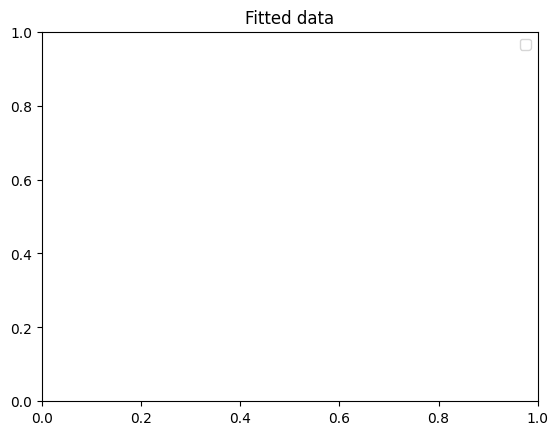

In [71]:
# Attempt to automate this
# Numbers in the file names of data that we want to fit
file_num = [35]
mod = ExpressionModel('off + amp * (sin(x*freq + phase))**2')
params = mod.make_params(off=0.25, amp=-0.001, freq=2, phase=15)
fit_list = []

for num in file_num:
    file_name = r"C:\Users\18434\Downloads\Colim_" + str(num) + ".lvm"
    data = fileOpener(file_name, [0,3])
    x_data = data[:, 0]
    y_data = data[:, 1]
    my_fit = model_fit_and_plot(x_data, y_data, mod, params)
    fit_list.append(my_fit)

In [72]:
# File 35
fit_list[0]

name,value,standard error,relative error,initial value,min,max,vary
off,4.68483237,0.00252142,(0.05%),0.25,-inf,inf,True
amp,8.2630e-05,0.00414600,(5017.57%),-0.001,-inf,inf,True
freq,2.00020416,0.00706047,(0.35%),2.0,-inf,inf,True
phase,14.3075789,36.4482304,(254.75%),15.0,-inf,inf,True


In [46]:
# File 39
fit_list[1]

name,value,standard error,relative error,initial value,min,max,vary
off,4.98456660,2.4613e-04,(0.00%),0.25,-inf,inf,True
amp,-0.00116926,4.0179e-04,(34.36%),1.0,-inf,inf,True
freq,1.97862264,9.2845e-04,(0.05%),2.0,-inf,inf,True
phase,7.42760127,0.34398920,(4.63%),0.0,-inf,inf,True


In [74]:
import gwpy

In [ ]:
stride = 0.005